In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import Optimization_function as opt
import copy

## Data Input and Parameters Setting

In [2]:
path = 'Data/backtest'
etf_price = pd.DataFrame(data = None)
col_name = []
for file in os.listdir(path):
    temp_df = pd.read_csv(path+'/'+file,index_col = 0)
    etf_price = etf_price.join(temp_df['Adj Close'], how = 'outer', rsuffix = '_'+file.replace('.csv',''))
    col_name.append(file.replace('.csv',''))
etf_price.columns = col_name

In [3]:
etf_rtn = etf_price.pct_change()[1:]

In [4]:
window_length = 60 #Set 5 years as the window length to calculate parameters
#t = 10 #Set risk tolerance parameter
eta = 0.75 #Set confidence level

In [6]:
etf_rtn.tail()

,DBC,GLD,SHY,SPIB,VB,VGLT,VO,VOO,VWO
Date,,,,,,,,,
2020-03-01,-0.173402,-0.002224,0.012571,-0.052900,-0.222364,0.064558,-0.188097,-0.128505,-0.172014
2020-04-01,-0.031111,0.072611,0.002962,0.042600,0.149606,0.009570,0.148087,0.133156,0.080106
2020-05-01,0.080734,0.025882,-0.000390,0.019863,0.076527,-0.017065,0.072678,0.047360,0.032900
2020-06-01,0.044992,0.027377,0.000253,0.016935,0.023602,0.003429,0.016055,0.013155,0.060225
2020-07-01,0.042242,0.033638,0.000462,0.010563,0.040357,0.021065,0.055706,0.059106,0.101142


## Optimization Implementation

In [25]:
def portfolio_evaluation(portfolio_performance, risk_free_rate = 0.0):
    portfolio_evaluation = pd.DataFrame(data = None, index = portfolio_performance.columns)
    
    annual_rtn = pd.DataFrame(portfolio_performance.mean()*12)
    annual_rtn.columns = ['annualized return']
    annual_vol = pd.DataFrame(portfolio_performance.std()*np.sqrt(12))
    annual_vol.columns = ['annualized volatility']
    
    excess_rtn = portfolio_performance - risk_free_rate
    Sharpe_ratio = pd.DataFrame(excess_rtn.mean()*12/(excess_rtn.std()*np.sqrt(12)))
    Sharpe_ratio.columns = ['Sharpe ratio']
    
    cumulative_r = (portfolio_performance+1).cumprod()
    dd = 1-cumulative_r/cumulative_r.expanding(min_periods=1).max()
    MDD = pd.DataFrame(dd.max(axis = 0))
    MDD.columns = ['maximum drawdown']
    
    portfolio_evaluation = portfolio_evaluation.join(annual_rtn)
    portfolio_evaluation = portfolio_evaluation.join(annual_vol)
    portfolio_evaluation = portfolio_evaluation.join(Sharpe_ratio)
    portfolio_evaluation = portfolio_evaluation.join(MDD)
    
    return portfolio_evaluation

In [24]:
def optimization_implementation(return_df, window_length, eta, target_risk, t, method = 'target risk'):
    portfolio_return = pd.DataFrame(data = None, index = return_df.index[window_length:], columns = ['mean_variance', 'robust'])
    mv_weight = pd.DataFrame(data = None, index = return_df.index[window_length:], columns = col_name)
    robust_weight = pd.DataFrame(data = None, index = return_df.index[window_length:], columns = col_name)
    
    for i in range(len(return_df) - window_length):
        sample_mean = return_df.iloc[i:(i+window_length),:].mean().values
        sample_cov = return_df.iloc[i:(i+window_length),:].cov().values
        sigma = np.diag(np.diag(sample_cov))/window_length
        
        if method == 'target risk':
            risk_level = target_risk/np.sqrt(12)
            w1 = opt.Markovitz_opt_risktarget(sample_mean, sample_cov, risk_level)
            r1 = np.dot(w1.T, return_df.iloc[(i+window_length),:].values)[0]
            
            w2 = opt.Robust_opt_risktarget(sample_mean, sample_cov, sigma, eta, risk_level)
            r2 = np.dot(w2.T, return_df.iloc[(i+window_length),:].values)[0]
        
        elif method == 'global':
            w1 = opt.Markovitz_opt(sample_mean, sample_cov, t)
            r1 = np.dot(w1.T, return_df.iloc[(i+window_length),:].values)[0]
    
            w2 = opt.Robust_opt(sample_mean, sample_cov, sigma, t, eta)
            r2 = np.dot(w2.T, return_df.iloc[(i+window_length),:].values)[0]
            
       #print(np.sqrt(12)*np.sqrt(np.dot(w1.T, np.dot(sample_cov, w1))),np.sqrt(12)*np.sqrt(np.dot(w2.T, np.dot(sample_cov, w2))))
        portfolio_return.iloc[i, 0] = r1
        portfolio_return.iloc[i, 1] = r2
            
        mv_weight.iloc[i, :] = w1.T
        robust_weight.iloc[i, :] = w2.T
        
    fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (18,4))
    mv_weight.plot(kind = 'area', ax = axes[0], title = 'Asset weights under Markowitz mean-variance optimization')
    robust_weight.plot(kind = 'area', ax = axes[1], title = 'Asset weights under Robust optimization')
        
    portfolio_return_plt = copy.copy(portfolio_return)
    portfolio_return_plt.loc[return_df.index[window_length]] = 0.0
    (portfolio_return_plt+1).cumprod().plot(ax = axes[2], title = 'Return Comparison')
        
    portfolio_eval = portfolio_evaluation(portfolio_return, risk_free_rate = 0.0)
        
    return portfolio_eval

### Results Comparison: different risk tolerance parameter

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.112261,0.114731,0.978464,0.136734
robust,0.064464,0.051267,1.257405,0.068469


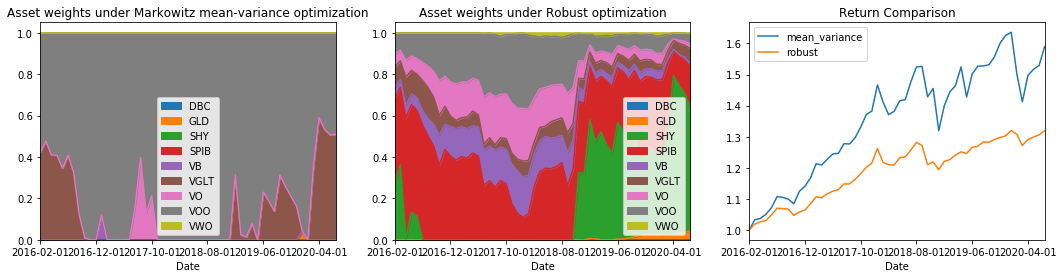

In [7]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = None, t = 0.5, method = 'global')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.113453,0.126035,0.900168,0.17099
robust,0.071827,0.061502,1.167889,0.08988


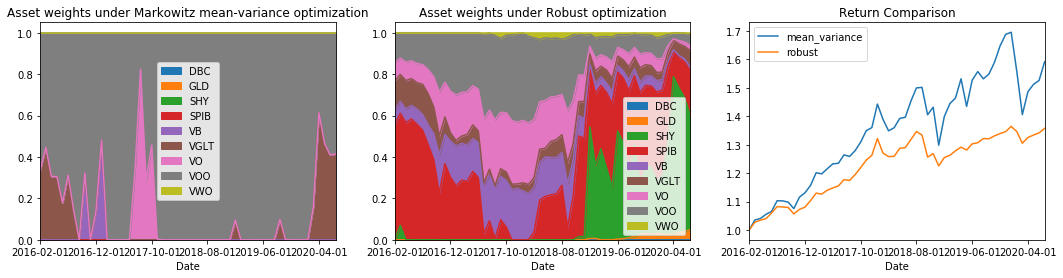

In [8]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = None, t = 1, method = 'global')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109352,0.137088,0.797682,0.199094
robust,0.081002,0.073023,1.109273,0.109994


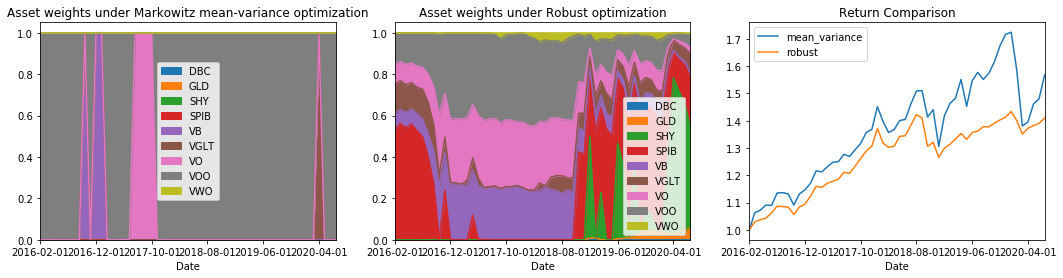

In [9]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = None, t = 10, method = 'global')

### Results Comparison: different target risk level

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.083416,0.061919,1.347176,0.066881
robust,0.059693,0.050840,1.174152,0.069797


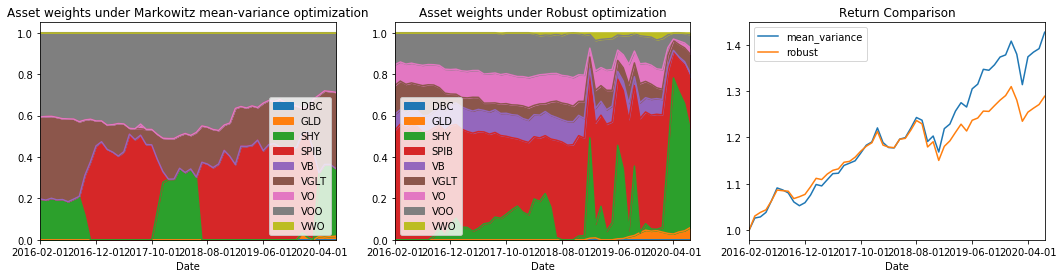

In [31]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.05, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.122673,0.091334,1.343132,0.103789
robust,0.071894,0.065964,1.089895,0.102386


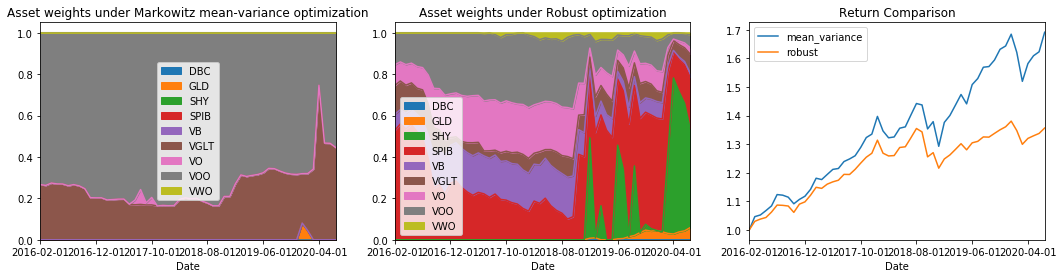

In [26]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.08, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.121236,0.117032,1.035919,0.149322
robust,0.079758,0.072626,1.098208,0.110963


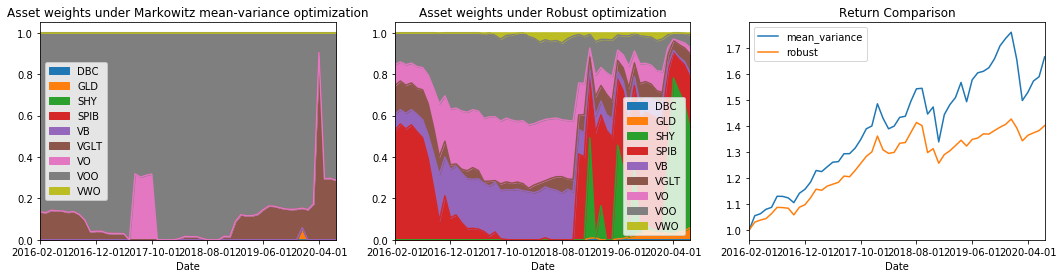

In [27]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.10, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.110565,0.132934,0.831727,0.191593
robust,0.081998,0.073648,1.113377,0.110981


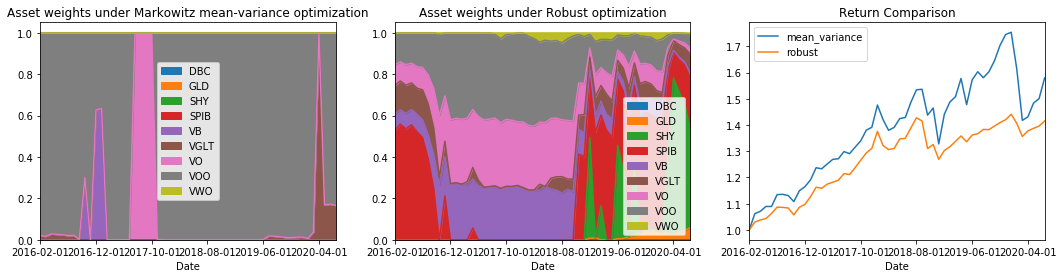

In [28]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.12, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109069,0.137062,0.795763,0.199093
robust,0.081995,0.073665,1.113073,0.110995


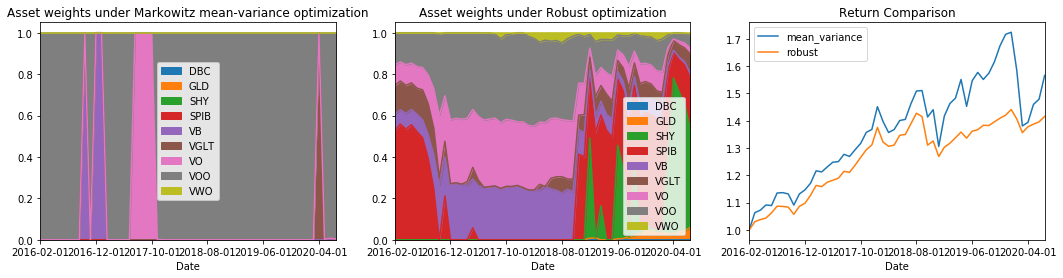

In [29]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.15, t = None, method = 'target risk')

,annualized return,annualized volatility,Sharpe ratio,maximum drawdown
mean_variance,0.109161,0.137087,0.796293,0.199093
robust,0.081992,0.073669,1.112977,0.111011


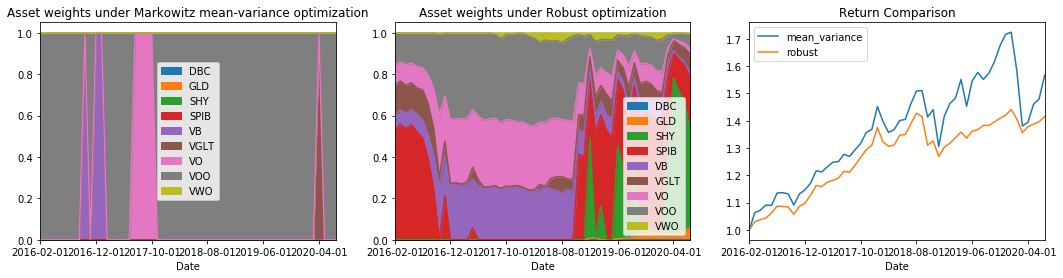

In [30]:
optimization_implementation(etf_rtn, window_length, eta, target_risk = 0.20, t = None, method = 'target risk')